<a href="https://colab.research.google.com/github/gened1080/noise/blob/main/Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ThinkDSP

This notebook contains code examples from Chapter 4: Noise

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf noise
git clone https://github.com/gened1080/noise.git

Cloning into 'noise'...


In [3]:
from __future__ import print_function, division

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("/content/noise")

import os
if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

if not os.path.exists('thinkplot.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkplot.py

if not os.path.exists('thinkstats2.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkstats2.py

import thinkdsp
import thinkplot
import thinkstats2 

import numpy as np

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

--2020-10-23 13:28:42--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkstats2.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkstats2.py [following]
--2020-10-23 13:28:42--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkstats2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75264 (74K) [text/plain]
Saving to: ‘thinkstats2.py’

thinkstats2.py      100%[===================>]  73.50K  --.-KB/s    in 0.03s   

2020-10-23 13:28:42 (2.57 MB/s) - ‘thinkstats2.py’ saved [75264/75264]



In [4]:
thinkdsp.random_seed(17)

The simplest noise to generate is uncorrelated uniform (UU) noise:

In [5]:
signal = thinkdsp.UncorrelatedUniformNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.make_audio()

Here's what a segment of it looks like:

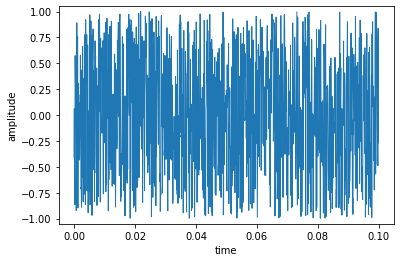

In [6]:
segment = wave.segment(duration=0.1)
segment.plot(linewidth=1)
thinkplot.config(xlabel='time',
                 ylabel='amplitude',
                 ylim=[-1.05, 1.05],
                 legend=False)

And here's the spectrum:

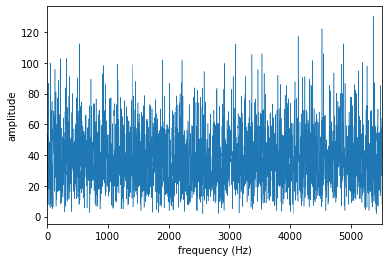

In [7]:
spectrum = wave.make_spectrum()
spectrum.plot(linewidth=0.5)
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='amplitude',
                 xlim=[0, spectrum.fs[-1]])

In the context of noise it is more conventional to look at the spectrum of power, which is the square of amplitude:

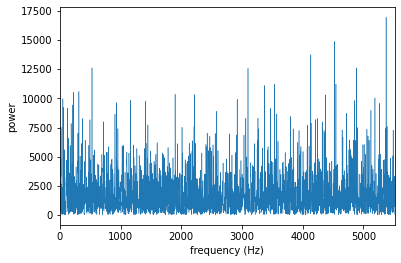

In [8]:
spectrum.plot_power(linewidth=0.5)
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='power',
                 xlim=[0, spectrum.fs[-1]])

UU noise has the same power at all frequencies, on average, which we can confirm by looking at the normalized cumulative sum of power, which I call an integrated spectrum:

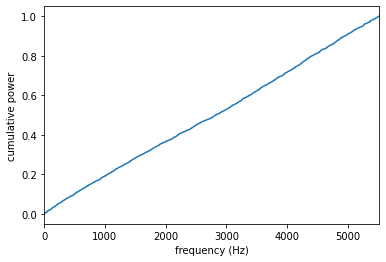

In [9]:
integ = spectrum.make_integrated_spectrum()
integ.plot_power()
thinkplot.config(xlabel='frequency (Hz)',
                ylabel='cumulative power',
                xlim=[0, spectrum.fs[-1]])

A straight line in this figure indicates that UU noise has equal power at all frequencies, on average.  By analogy with light, noise with this property is called "white noise".

### Brownian noise

Brownian noise is generated by adding up a sequence of random steps.

In [10]:
signal = thinkdsp.BrownianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.make_audio()

The sound is less bright, or more muffled, than white noise.

Here's what the wave looks like:

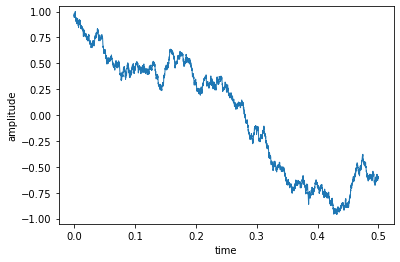

In [11]:
wave.plot(linewidth=1)
thinkplot.config(xlabel='time',
                 ylabel='amplitude',
                 ylim=[-1.05, 1.05])

Here's what the power spectrum looks like on a linear scale.

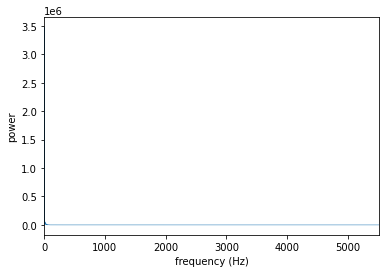

In [12]:
spectrum = wave.make_spectrum()
spectrum.plot_power(linewidth=0.5)
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='power',
                 xlim=[0, spectrum.fs[-1]])

So much of the energy is at low frequencies, we can't even see the high frequencies.

We can get a better view by plotting the power spectrum on a log-log scale.

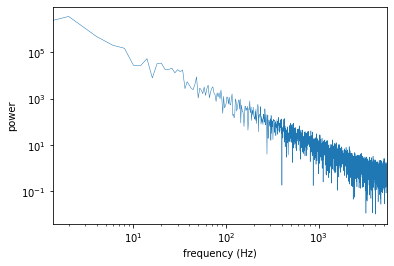

In [13]:
# The f=0 component is very small, so on a log scale
# it's very negative.  If we clobber it before plotting,
# we can see the rest of the spectrum better.
spectrum.hs[0] = 0

spectrum.plot_power(linewidth=0.5)
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='power',
                 xscale='log',
                 yscale='log',
                 xlim=[0, spectrum.fs[-1]])

Now the relationship between power and frequency is clearer.  The slope of this line is approximately -2, which indicates that $P = K / f^2$, for some constant $K$.

In [14]:
signal = thinkdsp.BrownianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
spectrum = wave.make_spectrum()
result = spectrum.estimate_slope()
result.slope

-1.784603221122176

The estimated slope of the line is closer to -1.8 than -2, for reasons we'll see later.

### Pink noise

Pink noise is characterized by a parameter, $\beta$, usually between 0 and 2.  You can hear the differences below.

With $\beta=0$, we get white noise:

In [15]:
signal = thinkdsp.PinkNoise(beta=0)
wave = signal.make_wave(duration=0.5)
wave.make_audio()

With $\beta=1$, pink noise has the relationship $P = K / f$, which is why it is also called $1/f$ noise.

In [16]:
signal = thinkdsp.PinkNoise(beta=1)
wave = signal.make_wave(duration=0.5)
wave.make_audio()

With $\beta=2$, we get Brownian (aka red) noise.

In [17]:
signal = thinkdsp.PinkNoise(beta=2)
wave = signal.make_wave(duration=0.5)
wave.make_audio()

The following figure shows the power spectrums for white, pink, and red noise on a log-log scale.

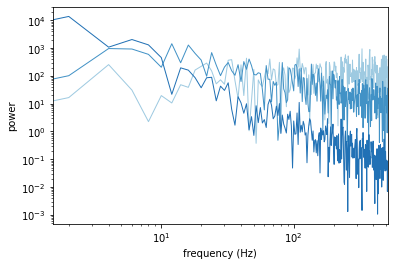

In [18]:
colors = ['#9ecae1', '#4292c6', '#2171b5']
betas = [0, 1, 2]

for beta, color in zip(betas, colors):
    signal = thinkdsp.PinkNoise(beta=beta)
    wave = signal.make_wave(duration=0.5, framerate=1024)
    spectrum = wave.make_spectrum()
    spectrum.hs[0] = 0
    spectrum.plot_power(linewidth=1, color=color)
    
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='power',
                 xscale='log',
                 yscale='log',
                 xlim=[0, spectrum.fs[-1]])

### Uncorrelated Gaussian noise

An alternative to UU noise is uncorrelated Gaussian (UG noise).

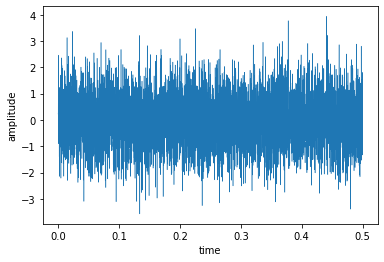

In [19]:
signal = thinkdsp.UncorrelatedGaussianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.plot(linewidth=0.5)
thinkplot.config(xlabel='time',
                 ylabel='amplitude')

The spectrum of UG noise is also UG noise.

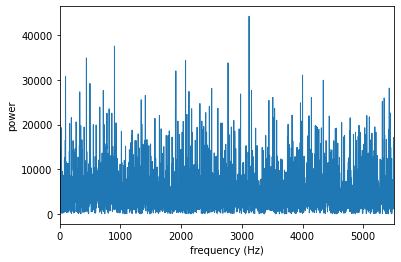

In [20]:
spectrum = wave.make_spectrum()
spectrum.plot_power(linewidth=1)
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='power',
                 xlim=[0, spectrum.fs[-1]])

We can use a normal probability plot to test the distribution of the power spectrum.

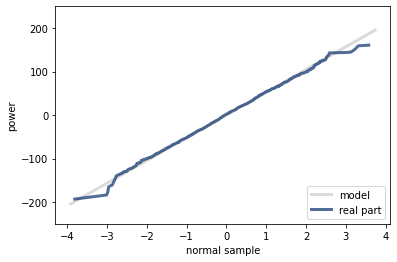

In [21]:
from thinkstats2 import NormalProbabilityPlot

NormalProbabilityPlot(spectrum.real, label='real part')
thinkplot.config(xlabel='normal sample',
                 ylabel='power',
                 ylim=[-250, 250],
                 legend=True,
                 loc='lower right')

A straight line on a normal probability plot indicates that the distribution of the real part of the spectrum is Gaussian.

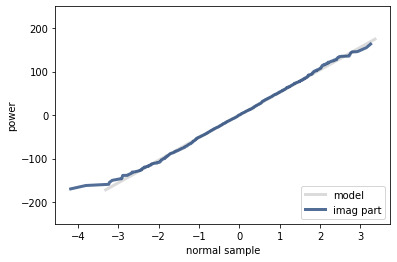

In [22]:
NormalProbabilityPlot(spectrum.imag, label='imag part')
thinkplot.config(xlabel='normal sample',
                 ylabel='power',
                 ylim=[-250, 250],
                 legend=True,
                 loc='lower right')

And so is the imaginary part.